# Train with stable baselines 

In [22]:
import os

import gym
import gym_defender

from stable_baselines.common.policies import FeedForwardPolicy as FFP_common
from stable_baselines.deepq.policies import FeedForwardPolicy as FFP_DQ

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.bench import Monitor

from stable_baselines import PPO2
from stable_baselines import DQN

from stable_baselines.results_plotter import load_results, ts2xy

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MLP_PPO(FFP_common):
    def __init__(self, *args, **kwargs):
        super(MLP_PPO, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[300, 300], vf=[300, 300])],
                                           feature_extraction="mlp")
        
class MLP_DQN(FFP_DQ):
    def __init__(self, *args, **kwargs):
        super(MLP_DQN, self).__init__(*args, **kwargs,
                                           layers=[300, 300],
                                           layer_norm=False,
                                           feature_extraction="mlp")


In [32]:
class Defense:
    def __init__(self, method, K=5, P=0.95):
        self.method = method
        
        self.K = K
        self.state_size        = 2 * (self.K + 1)
        self.action_size       = 2
        self.reward            = []
        
        env_name = 'defender-' + str(K) + '-' + str(P) + '-v1'
        
        self.log_dir = "/tmp/gym/"
        os.makedirs(self.log_dir, exist_ok=True)
        
        env = gym.make(env_name)
        env = Monitor(env, self.log_dir, allow_early_resets=True)
        self.envs = DummyVecEnv([lambda: env])
        
        if method=='PPO':
            self.model = PPO2(MLP_PPO, self.envs, verbose=0)
        elif method=='DQN':
            self.model = DQN(MLP_DQN, self.envs, verbose=0)
        else:
            raise Exception("Erreur ! Méthode: 'PPO' ou 'DQN'")
        print("Model Initialized !")
        
        self.best_mean_reward, self.n_steps = -np.inf, 0
        
    
    def callback(self, _locals, _globals):
        """
        Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
        :param _locals: (dict)
        :param _globals: (dict)
        """
       
        # Print stats every 1000 calls
        if (self.n_steps + 1) % 1000 == 0:
            # Evaluate policy performance
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                print(x[-1], 'timesteps')
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                
        self.n_steps += 1
        return True
    
    def learn(self, timesteps=10000):
        self.model.learn(total_timesteps = timesteps, callback = self.callback)
        print("======\nLEARNING DONE\n======")

    def save(self, filename):
        self.model.save(filename)
        print("Model saved !\n Filename:", filename)

    def load(self, filename):
        if self.method=='PPO':
            self.model = PPO2.load(filename, policy=MLP_PPO)
        else:
            self.model = DQN.load(filename, policy=MLP_DQN)
        print("Model loaded !")
        
    
    
    def run(self, nb_episodes = 1000):
        self.nb_episodes = nb_episodes
        
        for index_episode in range(nb_episodes):
            state = self.envs.reset()
            state = np.reshape(np.array(state), [1, self.state_size])
            done = False
            steps = 0
            while not done:
                 action, _states = self.model.predict(state)
                 next_state, reward, done, _ = self.envs.step(action)
                 next_state = np.reshape(np.array(next_state), [1, self.state_size])
                 state = next_state
                 steps += 1
            if index_episode %100 == 0:
                print("Episode {}#; \t Nb of steps: {}; \t Reward: {}.".format(index_episode, steps + 1, reward))
            if index_episode > 0:
                self.reward += [((self.reward[-1] * len(self.reward)) + reward) / (len(self.reward) + 1)]
            else:
                self.reward += [reward]

In [38]:
defense = Defense('DQN', K=5, P=0.99)
defense.learn(10000)
#defense.run(1000)
#plt.plot(range(1, defense.nb_episodes+1), defense.reward)

Model Initialized !
998 timesteps
Best mean reward: -inf - Last mean reward per episode: -0.40
1996 timesteps
Best mean reward: -0.40 - Last mean reward per episode: 0.68
2996 timesteps
Best mean reward: 0.68 - Last mean reward per episode: 0.94
3999 timesteps
Best mean reward: 0.94 - Last mean reward per episode: 0.92
4997 timesteps
Best mean reward: 0.94 - Last mean reward per episode: 0.88
5997 timesteps
Best mean reward: 0.94 - Last mean reward per episode: 0.96
6999 timesteps
Best mean reward: 0.96 - Last mean reward per episode: 0.92
7999 timesteps
Best mean reward: 0.96 - Last mean reward per episode: 0.88
8995 timesteps
Best mean reward: 0.96 - Last mean reward per episode: 0.90
9999 timesteps
Best mean reward: 0.96 - Last mean reward per episode: 0.90
LEARNING DONE


In [16]:
defense.save('DQN_10_0.99_1k')

Model saved !
 Filename: DQN_10_0.99_1k


### Models saved
------
- DQN_5_0.95_20k
- PPO_5_0.99_10k
- PPO_10_0.99_1k
- DQN_10_0.99_1k


In [41]:
def movingAverage(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = movingAverage(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

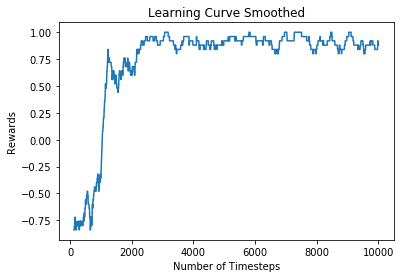

In [42]:
log_dir = "/tmp/gym/"
plot_results(log_dir)